In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shutil 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import numpy as np
import torchvision
import time
import copy

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', 'plates', '.virtual_documents']


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [3]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [4]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 13 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [5]:
!ls train

cleaned  dirty


In [6]:
print(len(os.listdir('/kaggle/working/plates/train/cleaned')))
print(len(os.listdir('/kaggle/working/plates/train/dirty')))

# видим, что количество примеров в каждом классе одинаково. это хорошо

21
21


In [7]:
from torchvision import transforms, models

train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(p=0.5)
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
print(len(train_dataloader), len(train_dataset))
len(val_dataloader), len(val_dataset)

10 38


(1, 2)

In [9]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [10]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=False, num_workers=0)

In [11]:
len(test_dataset)

744

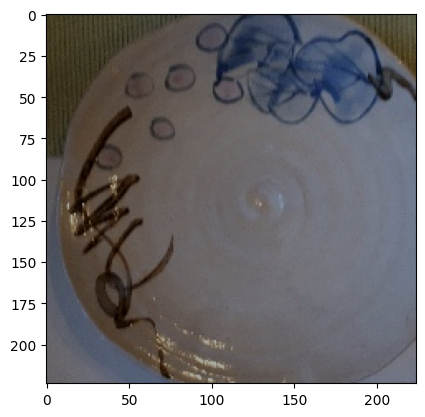

In [12]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [13]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

# X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

In [14]:
def plotting_train(train_loss, val_loss, train_acc, val_acc):
    """
    После каждой эпохи обучения интерактивно выводятся два графика. Первый с loss, второй с error.
    """
    fig, axes = plt.subplots(1, 2, figsize=(17, 4))
    axes[0].plot(train_loss, label="train_loss")
    axes[0].plot(val_loss, label="val_loss")
    axes[0].axvline(x = val_loss.index(min(val_loss)), color = 'g', linestyle = ':')
    axes[1].plot(train_acc, label="train_acc")
    axes[1].plot(val_acc, label="val_acc")
    axes[1].axvline(x = val_acc.index(max(val_acc)), color = 'g', linestyle = ':')
    x = val_acc.index(max(val_acc))
    y = max(val_acc)
    axes[1].annotate(text=f'{max(val_acc)*100:.2f}', xy=(x, y),
                     xycoords='data',
                     xytext=(x-0.01, y+0.01),
                     textcoords='data',
                     size=9,
                     va='bottom', ha='right')
    for i in [0,1]:
        axes[i].set_xticks(
            ticks=range(0, len(train_loss)), 
            labels=(x for x in range(1, len(train_loss)+1))
        )
        axes[i].legend()
    
    plt.show()

In [15]:

@torch.no_grad()
def get_predicts(model, name_model=''):
    
    model.eval()
    # загружаю веса модели, сохранённой с минимальным loss
    # model.load_state_dict(
    #     torch.load(f'/kaggle/working/{name_model}.pt', weights_only=False)
    # )
    
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        probs = model(inputs)
        predictions = torch.nn.functional.softmax(probs, dim=1)[:,1].data.cpu().numpy()
        test_predictions.append(predictions)
        test_img_paths.extend(paths)
        
    test_predictions = np.concatenate(test_predictions)

    return test_predictions, test_img_paths

In [16]:
from IPython.display import clear_output

def train_model(model, loss, optimizer, scheduler, num_epochs, name_model=''):
    
    history = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        
        model.train()

        train_loss = 0.
        train_acc = 0.
        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)
            # statistics
            train_loss += loss_value.item()
            train_acc += (preds_class == labels.data).float().mean().item()
            loss_value.backward()
            optimizer.step()
        scheduler.step()          
        
        #
        model.eval()

        val_loss = 0.
        val_acc = 0.
        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)
                    
                # statistics
                val_loss += loss_value.item()
                val_acc += (preds_class == labels.data).float().mean().item()

        train_loss, train_acc = train_loss / len(train_dataloader), train_acc / len(train_dataloader)
        val_loss, val_acc = val_loss / len(val_dataloader), val_acc / len(val_dataloader)

        # checkpoint...
        ckpt_path = '/kaggle/working/'
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/{name_model}.pt')

        
        # Сохраняю значения для построения графиков
        history.append((train_loss, val_loss, train_acc, val_acc))
        
        clear_output(wait=True)
        print(f'{epoch+1} Val_loss: {val_loss:.3f} Accuracy: {val_acc*100:.2f}')

        train_loss1, val_loss1, train_acc1, val_acc1 = zip(*history)
        plotting_train(train_loss1, val_loss1, train_acc1, val_acc1)

    return model

In [82]:
model1 = models.resnet18(weights='DEFAULT')
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

60 Val_loss: 0.024 Accuracy: 100.00


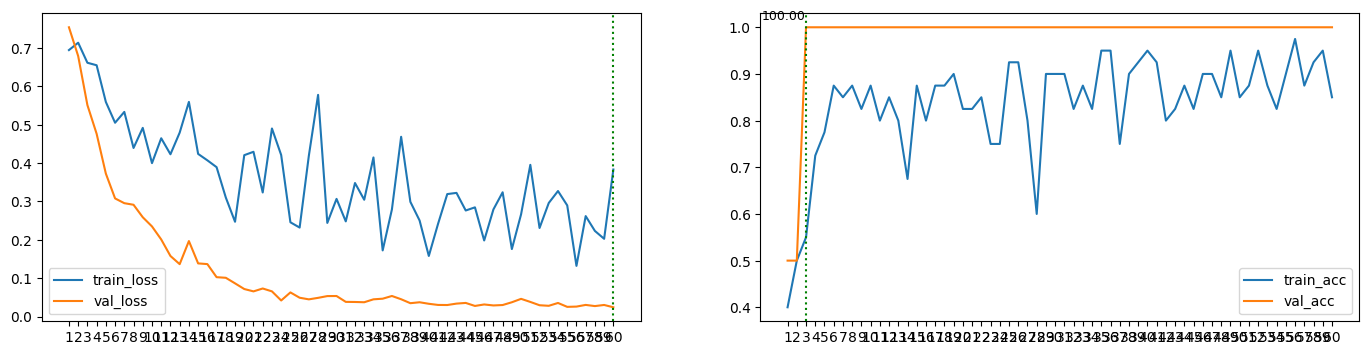

In [83]:
model1 = models.resnet18(weights='DEFAULT')

# Disable grad for all conv layers
for param in model1.parameters():
    param.requires_grad = False

model1.fc = torch.nn.Sequential(
    torch.nn.Linear(model1.fc.in_features, 64),
    torch.nn.Linear(64, 2)
)

for param in model1.layer4.parameters():
    param.requires_grad = True

model1 = model1.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=1.0e-3, momentum=0.79)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

model1 = train_model(model1, loss, optimizer, scheduler, num_epochs=60, name_model='model_ce')

#### классический submission

In [84]:
test_predictions, test_img_paths = get_predicts(model1, name_model='model_ce')

  0%|          | 0/15 [00:00<?, ?it/s]

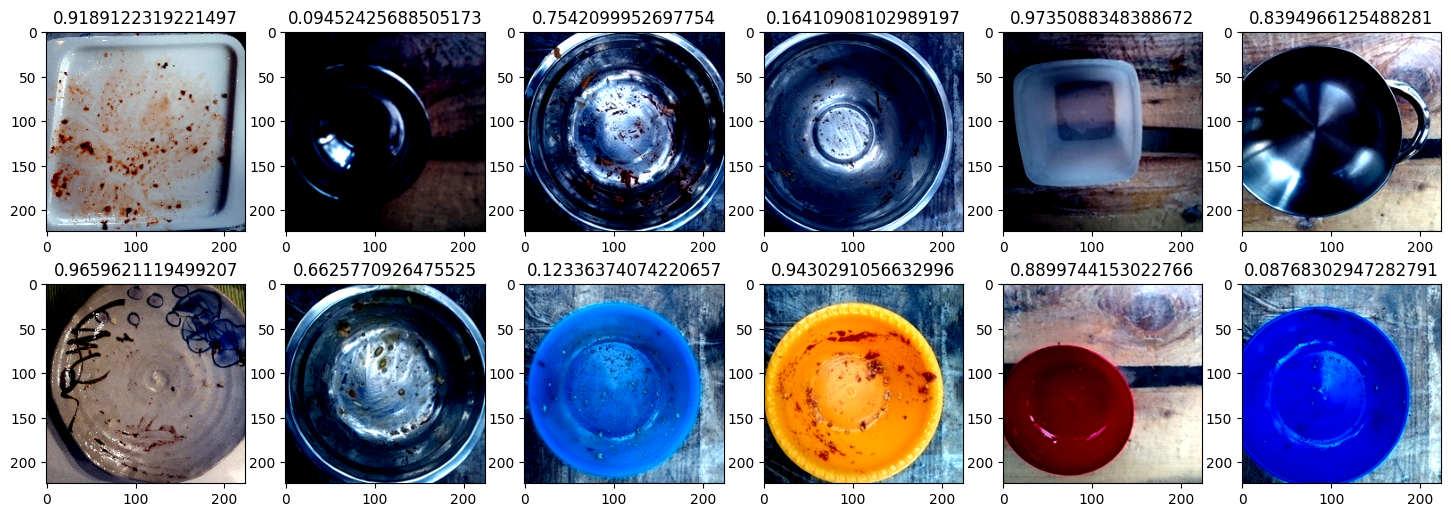

In [85]:
# смотрим на 12 тарелок и предсказанная вероятность того, что она грязная

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=0)
std = np.array([0.485, 0.456, 0.406]) 
mean = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(18, 6))
for inputs, targets, pat in test_dataloader:
    for idx, (img, pred) in enumerate(zip(inputs, test_predictions)):
        plt.subplot(2, 6, idx+1)
        plt.imshow(img.permute(1,2,0).numpy() * std + mean)
        plt.title(f'{pred}')
        if idx == 11: 
            break
    break
            

In [86]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [87]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.64 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
# submission_df.head(8)

In [88]:
submission_df.to_csv('submission.csv')

print('loading...')
plt.pause(2)
print('submission loaded on /kaggle/working')

loading...
submission loaded on /kaggle/working


#### мой submission

In [22]:
from scipy.spatial.distance import pdist

@torch.no_grad()
def get_labels(model):

    embedder = nn.Sequential(*(list(model.children())[:-1]))
    total_loader = torch.utils.data.DataLoader(
        train_dataset + val_dataset, batch_size=1, shuffle=False, num_workers=4)
    
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=4)

    test_img_paths = []
    labels = []

    model.eval()
    for inputs, _, paths in tqdm(test_dataloader):
        test_img_paths.append(paths[0])
        inputs = inputs.to(device)
        test_img_embedd = embedder(inputs).reshape(-1).cpu()
        
        distatce_dict = dict()
        for img, label in total_loader:
            img = img.to(device)
            img_embedd = embedder(img).reshape(-1).cpu()
            
            dist = pdist([test_img_embedd, img_embedd], 'cosine')
            distatce_dict[dist.item()] = label.item()

        classs = distatce_dict[min(distatce_dict)]
        labels.append(classs)
        
    
    return test_img_paths, labels

In [23]:
test_paths, test_classes = get_labels(model1)

  0%|          | 0/744 [00:00<?, ?it/s]

In [24]:
len(test_paths), len(test_classes)

(744, 744)

In [25]:
submission_df = pd.DataFrame.from_dict({'id': test_paths, 'label': test_classes})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred == 1 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(8)

,label
id,
0000,cleaned
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty


In [26]:
submission_df.to_csv('submission_new.csv')

### обучение на ArcFaceLoss

In [31]:
class ArcFaceLoss(nn.Module):
    """
    Рализация лосс функции ArcFaceLoss
    return: logits (чтобы можно было считать метрики), loss
    """
    def __init__(self, embedding_size, num_classes, margin=0.5, scale=64):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        # Веса последнего слоя
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size)).to(device)
        nn.init.normal_(self.weight, mean=0, std=0.01)  # Инициализация весов


    def forward(self, embeddings, labels):
        labels = labels.to(torch.long)

        # Нормализация embeddings и weights
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weights = F.normalize(self.weight, p=2, dim=1)

        # Вычисление косинусного сходства между эмбеддингами и весами
        cosine = F.linear(embeddings, weights)  # (batch_size, num_classes)
        cosine = torch.clamp(cosine, -1 + 1e-7, 1 - 1e-7)  # Ограничение значений для численной стабильности

        # Вычисление значения угла theta (углового зазора) для каждого класса
        theta = torch.acos(cosine)

        # One-hot кодирование меток
        one_hot_labels = F.one_hot(labels, self.num_classes)

        # Применение ArcFace границ и вычисление logits
        target_logits = torch.cos(theta + self.margin * (1 - one_hot_labels.float()))  # Применяем margin только к целевым классам
        logits = self.scale * torch.where(one_hot_labels.bool(), target_logits, cosine)  # Применяем scale

        # Вычисление кросс-энтропийной потери
        loss = F.cross_entropy(logits, labels)

        return logits, loss

In [32]:
from IPython.display import clear_output

def train_model_AF(model, loss, optimizer, scheduler, num_epochs, name_model=''):
    
    history = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        
        model.train()

        train_loss = 0.
        train_acc = 0.
        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            embeddings = model(inputs)
            logits, loss_value = loss(embeddings, labels)
            preds = torch.argmax(logits, 1)
            # statistics
            train_loss += loss_value.item()
            train_acc += (preds == labels.data).float().mean().item()
            
            loss_value.backward()
            optimizer.step()
        scheduler.step()          
        
        #
        model.eval()

        val_loss = 0.
        val_acc = 0.
        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                embeddings = model(inputs)
                logits, loss_value = loss(embeddings, labels)
                preds = torch.argmax(logits, 1)
                    
                # statistics
                val_loss += loss_value.item()
                val_acc += (preds == labels.data).float().mean().item()

        train_loss, train_acc = train_loss / len(train_dataloader), train_acc / len(train_dataloader)
        val_loss, val_acc = val_loss / len(val_dataloader), val_acc / len(val_dataloader)

        # checkpoint...
        ckpt_path = '/kaggle/working/'
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/{name_model}.pt')

        
        # Сохраняю значения для построения графиков
        history.append((train_loss, val_loss, train_acc, val_acc))
        
        clear_output(wait=True)
        print(f'{epoch+1} Val_loss: {val_loss:.3f} Accuracy: {val_acc*100:.2f}')

        train_loss1, val_loss1, train_acc1, val_acc1 = zip(*history)
        plotting_train(train_loss1, val_loss1, train_acc1, val_acc1)

    return model

In [57]:
class myArcfaceModel(nn.Module):
    def __init__(self, model, in_features, embedding_size):
        super(myArcfaceModel, self).__init__()
        self.in_features = in_features
        self.embedding_size = embedding_size

        self.embedder = nn.Sequential(*(list(model.children())[:-1]))  # удаляю classification layer
        self.fc1 = nn.Linear(in_features=self.in_features, out_features=self.embedding_size, bias=True) # добавляю fc layer
        # self.fc2 = nn.Linear(in_features=64, out_features=self.embedding_size, bias=True)

    def forward(self, x):
        x = self.embedder(x)
        x = x.reshape(-1, x.shape[1])
        x = self.fc1(x)
        # x = self.fc2(x)

        return x

15 Val_loss: 0.183 Accuracy: 100.00


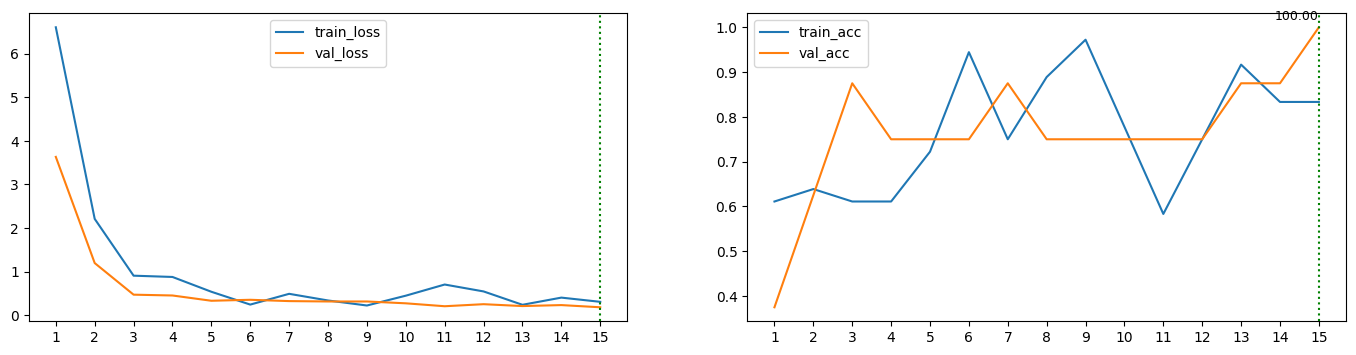

In [58]:
model_af = models.resnet18(weights='ResNet18_Weights.DEFAULT')

in_features = model_af.fc.in_features    # кол-во фичей, которые выдаёт embedder слой модели
embedding_size = 512  # размер вектора, который будет выдавать модель
output_classes = 2    # количество уникальных классов в датасете

model_af = myArcfaceModel(model_af, in_features, embedding_size)

# Disable grad for all conv layers
for param in model_af.parameters():
    param.requires_grad = False

for param in model_af.fc1.parameters():
    param.requires_grad = True

# for param in model_af.fc2.parameters():
#     param.requires_grad = True

model_af = model_af.to(device)

loss = ArcFaceLoss(embedding_size, output_classes, margin=0.4, scale=50)
optimizer = torch.optim.AdamW(model_af.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

model_af = train_model_AF(model_af, loss, optimizer, scheduler, num_epochs=15, name_model='model_af')

In [59]:
test_predictions_af, test_img_paths_af = get_predicts(model_af)

  0%|          | 0/15 [00:00<?, ?it/s]

In [64]:
test_predictions_af = np.array(test_predictions_af) * 1000
print(min(test_predictions_af))
print(np.mean(test_predictions_af))
print(max(test_predictions_af))

0.0015978357
0.26760167
4.4144473


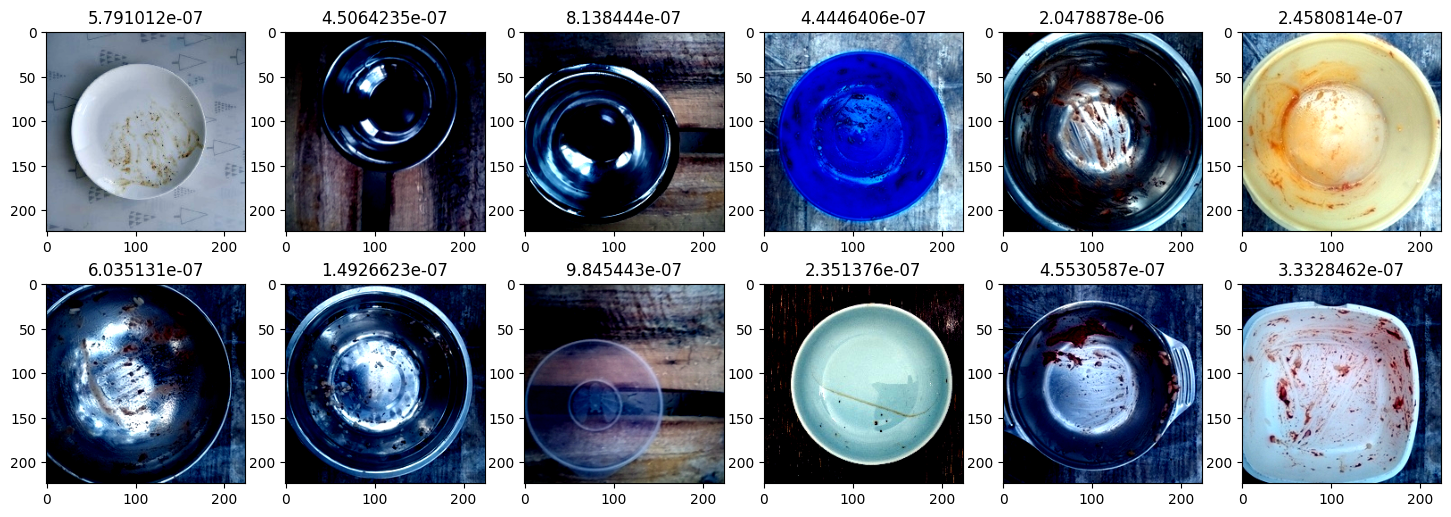

In [47]:
# смотрим на 12 тарелок и предсказанная вероятность того, что она грязная

inputs, labels, paths = next(iter(test_dataloader))
std = np.array([0.485, 0.456, 0.406]) 
mean = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(18, 6))
for idx, (img, pred) in enumerate(zip(inputs, test_predictions_af)):
    plt.subplot(2, 6, idx+1)
    plt.imshow(img.permute(1,2,0).numpy() * std + mean)
    plt.title(pred)
    if idx == 11: break

In [65]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths_af, 'label': test_predictions_af})

In [66]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.26760167 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(8)

,label
id,
0586,cleaned
0493,dirty
0349,cleaned
0388,cleaned
0487,cleaned
0611,dirty
0026,cleaned
0052,cleaned


In [67]:
submission_df.to_csv('submission_af.csv')

#### Возьмем среднее значение из трёх предсказаний

In [ ]:
test_predictions_af

In [ ]:
total_predictions = numpy.concatenate((test_predictions, test_classes, test_predictions_af), axis=0) / 3

In [ ]:
total_predictions

In [ ]:
# смотрим на 12 тарелок и предсказанная вероятность того, что она грязная

inputs, labels, paths = next(iter(test_dataloader))
std = np.array([0.485, 0.456, 0.406]) 
mean = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(18, 6))
for idx, (img, pred) in enumerate(zip(inputs, total_predictions)):
    plt.subplot(2, 6, idx+1)
    plt.imshow(img.permute(1,2,0).numpy() * std + mean)
    plt.title(pred)
    if idx == 11: break

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(8)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths_af, 'label': total_predictions})

In [ ]:
# !rm -rf train val test